<a href="https://colab.research.google.com/github/belladu0201/AIPI531_Deep-Reinforcement-Learning-and-Applications_SP23/blob/main/AIPI531_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 531: Deep Reinforcement Learning and Applications (SPRING 23)
Name: Beibei Du


## Installation

We will install master version of SB3.

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra] pyglet==1.5.27

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  freeglut3 freeglut3-dev xvfb
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 977 kB of archives.
After this operation, 3,350 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3-dev amd64 2.8.1-3 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 977 kB in 0s (2,155 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 128126 files and directories currently installed

Import DQN and evaluation helper

In [ ]:
import gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

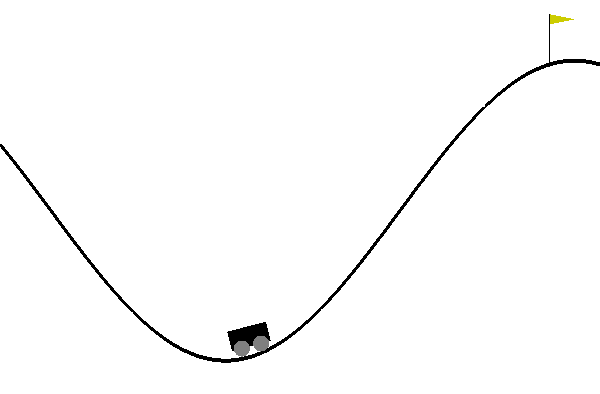


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [3]:
env = gym.make("MountainCar-v0")

Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [4]:
tensorboard_log = "data/tb/"

In [5]:
dqn_model = DQN("MlpPolicy",
            env,
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [6]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [ ]:
# Optional: Monitor training in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir $tensorboard_log

We will first train the agent until convergence and then analyse the learned q-value function.

In [7]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 406      |
|    time_elapsed     | 4        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 3.35e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 392      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.39e-

Evaluate after training, the mean episodic reward should have improved.

In [8]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-117.90 +/- 34.50


### Prepare video recording

In [9]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [10]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [11]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=False)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

## Visualize trained agent

In [12]:
record_video('MountainCar-v0', dqn_model, video_length=500, prefix='dqn-mountaincar')

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [13]:
show_videos('videos', prefix='dqn')

## Visualize Q-values

### Exercise (5 minutes): Retrieve q-values

The function will be used to retrieve the learned q-values for a given state (`observation` in the code).

The q-network from SB3 DQN can be accessed via `model.q_net` and is a PyTorch module (you can therefore call `.forward()` on it).

You need to convert the observation to a PyTorch tensor and then convert the resulting q-values to numpy array.

Note: It is recommended to use `with th.no_grad():` context to save computation and memory

In [31]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    # Retrieve q-values for the given observation and convert them to numpy
    ### use with th.no_grad() to save computation and memory
    with th.no_grad():
      obs_tensor = th.from_numpy(obs).unsqueeze(0)
      # get the q values from dqn_model using model.q_net
      q_values = dqn_model.q_net(obs_tensor).squeeze().cpu().numpy()
    
    ### END OF YOUR CODE
    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

### Q-values for the initial state

Let's reset the environment to start a new episode:

In [32]:
obs = env.reset()

we plot the rendered environment to visualize it

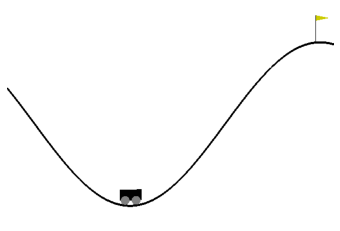

In [33]:
plt.axis('off')
plt.imshow(env.render(mode="rgb_array"))

### Exercise (5 minutes): predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [34]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [37]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`
q_values = get_q_values(dqn_model, obs)
q_value_left, q_value_nothing, q_value_right = q_values

### END OF YOUR CODE

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values 

# when following a greedy strategy
action = np.argmax(q_values)


## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-47.06 nothing=-40.48 right=-34.26
Action taken by the greedy policy in the initial state: Right


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [39]:
initial_q_value = q_values.max()
print(initial_q_value)

-34.262363


## Step until the end of the episode



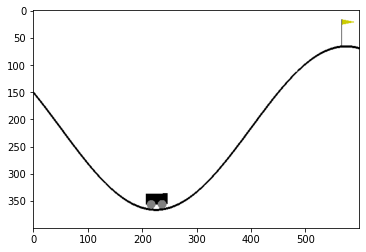

Q-value of the current state left=-47.06 nothing=-40.48 right=-34.26
Action: Right


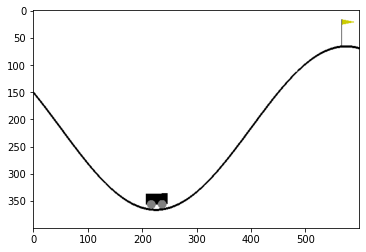

Q-value of the current state left=-45.57 nothing=-38.71 right=-31.77
Action: Right


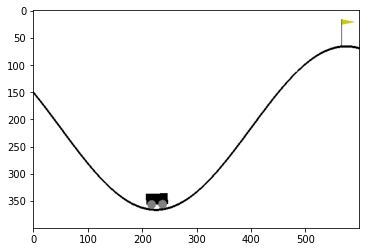

Q-value of the current state left=-44.02 nothing=-36.93 right=-29.28
Action: Right


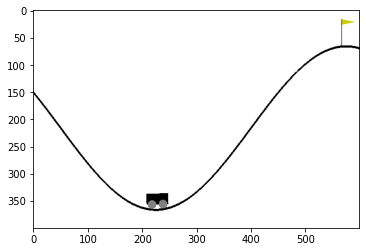

Q-value of the current state left=-42.44 nothing=-35.16 right=-26.85
Action: Right


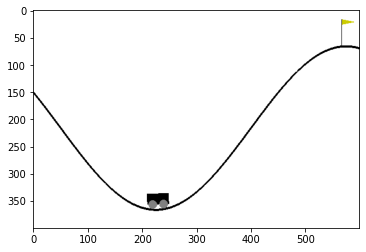

Q-value of the current state left=-40.79 nothing=-33.82 right=-25.45
Action: Right


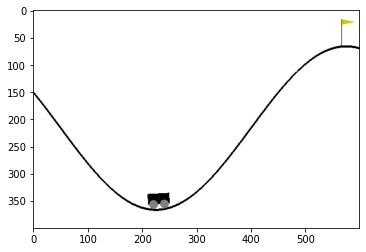

Q-value of the current state left=-39.07 nothing=-32.91 right=-25.12
Action: Right


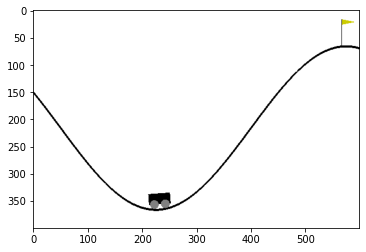

Q-value of the current state left=-37.26 nothing=-31.81 right=-24.54
Action: Right


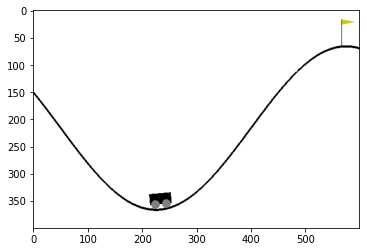

Q-value of the current state left=-35.90 nothing=-30.34 right=-23.22
Action: Right


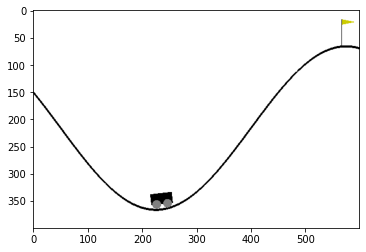

Q-value of the current state left=-34.59 nothing=-28.91 right=-21.95
Action: Right


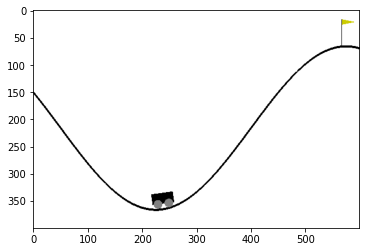

Q-value of the current state left=-33.38 nothing=-27.57 right=-20.79
Action: Right


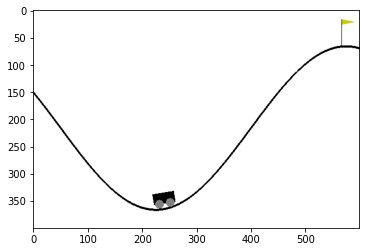

Q-value of the current state left=-33.57 nothing=-27.99 right=-21.87
Action: Right


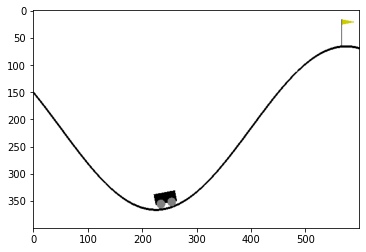

Q-value of the current state left=-32.98 nothing=-27.82 right=-22.64
Action: Right


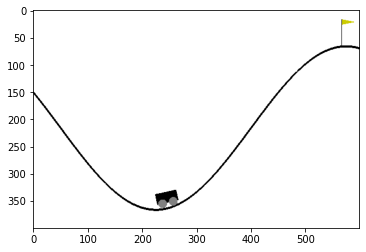

Q-value of the current state left=-31.03 nothing=-26.12 right=-21.84
Action: Right


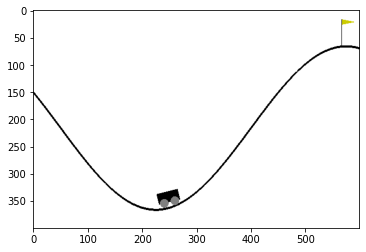

Q-value of the current state left=-29.31 nothing=-25.23 right=-21.88
Action: Right


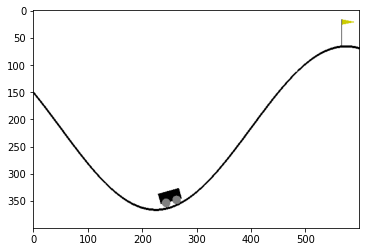

Q-value of the current state left=-27.82 nothing=-24.60 right=-22.23
Action: Right


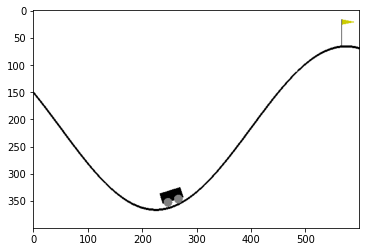

Q-value of the current state left=-26.36 nothing=-23.80 right=-22.49
Action: Right


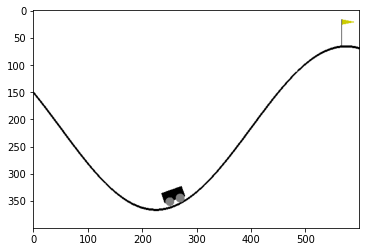

Q-value of the current state left=-20.43 nothing=-17.23 right=-17.02
Action: Right


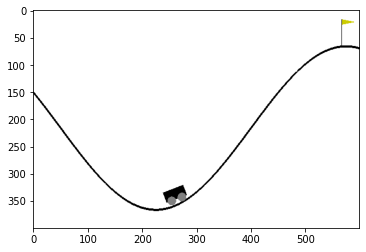

Q-value of the current state left=-15.27 nothing=-12.68 right=-13.36
Action: Nothing


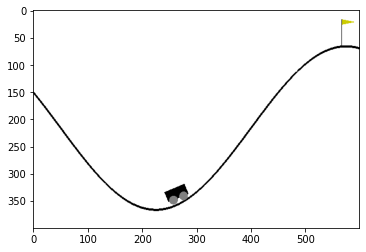

Q-value of the current state left=-13.15 nothing=-11.08 right=-12.95
Action: Nothing


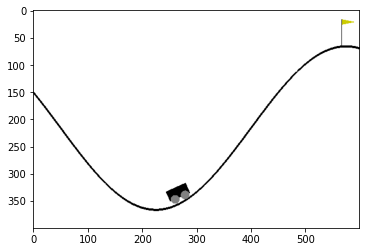

Q-value of the current state left=-12.14 nothing=-11.50 right=-14.46
Action: Nothing


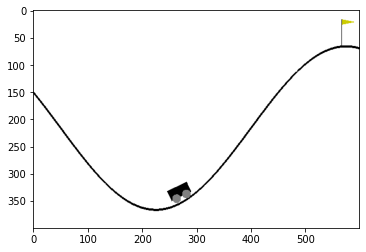

Q-value of the current state left=-11.51 nothing=-12.24 right=-16.12
Action: Left


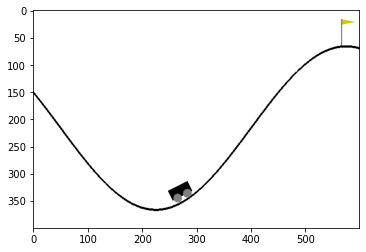

Q-value of the current state left=-12.93 nothing=-15.38 right=-19.77
Action: Left


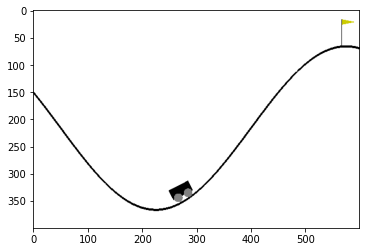

Q-value of the current state left=-12.99 nothing=-16.72 right=-21.08
Action: Left


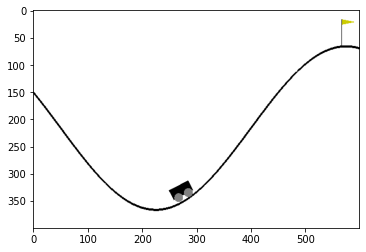

Q-value of the current state left=-8.28 nothing=-12.49 right=-15.90
Action: Left


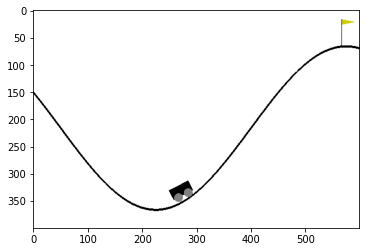

Q-value of the current state left=-4.55 nothing=-8.80 right=-10.97
Action: Left


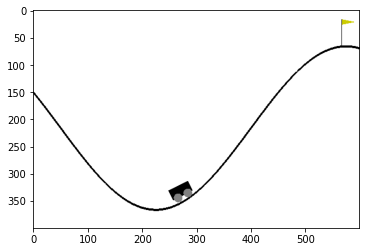

Q-value of the current state left=-4.33 nothing=-7.56 right=-8.04
Action: Left


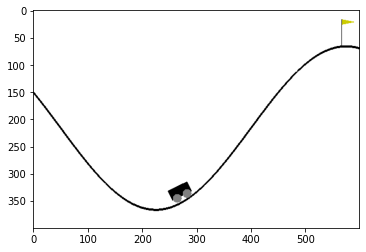

Q-value of the current state left=-2.90 nothing=-5.51 right=-4.75
Action: Left


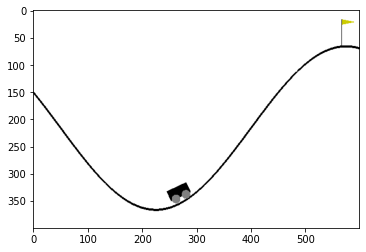

Q-value of the current state left=3.64 nothing=-0.96 right=-2.64
Action: Left


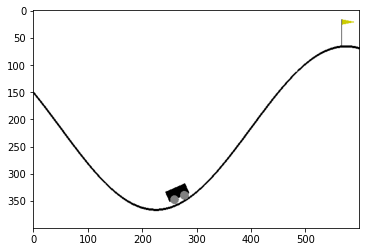

Q-value of the current state left=9.35 nothing=2.80 right=-1.16
Action: Left


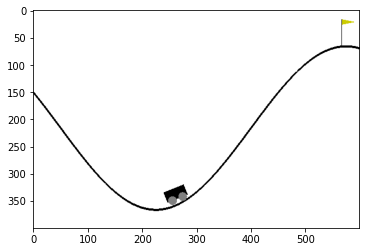

Q-value of the current state left=13.85 nothing=5.35 right=-0.74
Action: Left


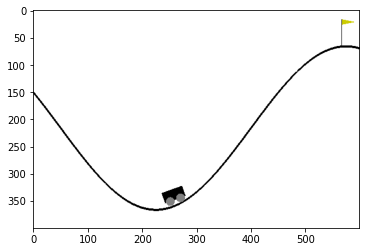

Q-value of the current state left=21.26 nothing=11.14 right=3.26
Action: Left


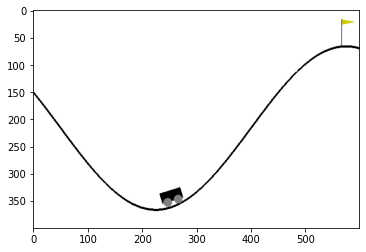

Q-value of the current state left=28.73 nothing=17.32 right=8.40
Action: Left


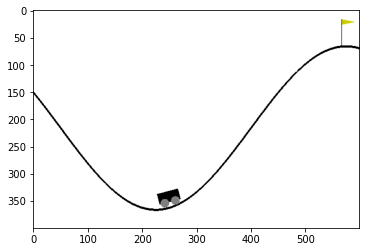

Q-value of the current state left=36.27 nothing=23.94 right=14.16
Action: Left


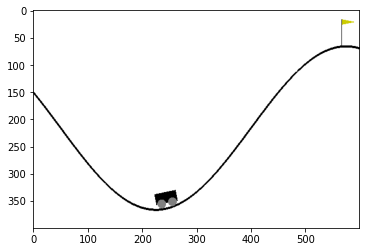

Q-value of the current state left=45.36 nothing=32.19 right=21.85
Action: Left


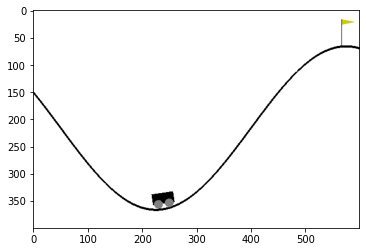

Q-value of the current state left=53.07 nothing=39.53 right=28.72
Action: Left


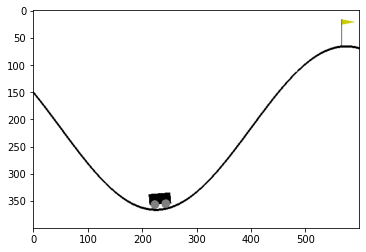

Q-value of the current state left=59.60 nothing=45.69 right=34.29
Action: Left


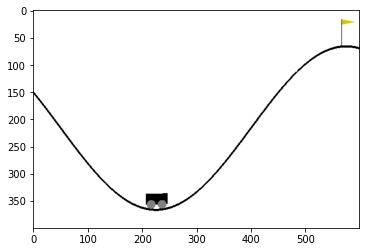

Q-value of the current state left=66.13 nothing=52.12 right=40.24
Action: Left


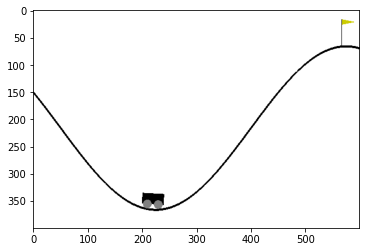

Q-value of the current state left=74.24 nothing=60.40 right=48.29
Action: Left


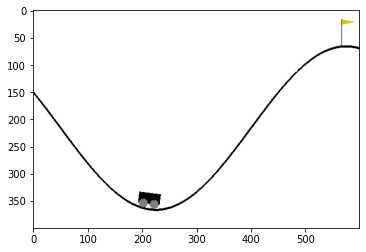

Q-value of the current state left=81.42 nothing=67.73 right=55.46
Action: Left


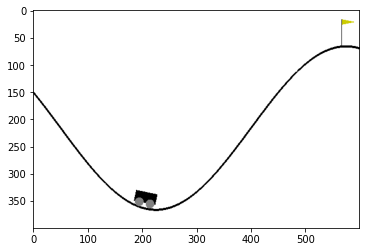

Q-value of the current state left=90.76 nothing=77.61 right=65.60
Action: Left


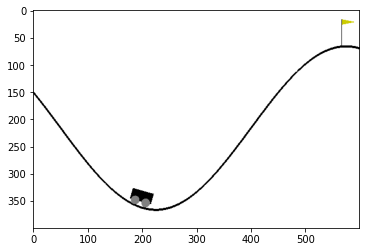

Q-value of the current state left=100.85 nothing=88.39 right=76.87
Action: Left


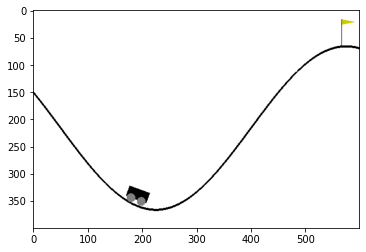

Q-value of the current state left=109.27 nothing=97.27 right=86.10
Action: Left


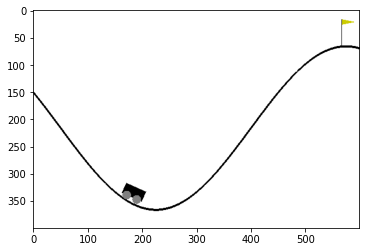

Q-value of the current state left=116.45 nothing=104.40 right=93.14
Action: Left


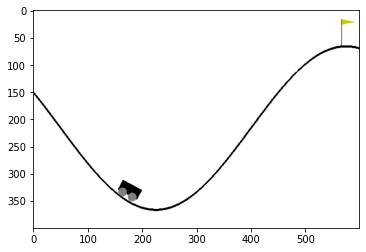

Q-value of the current state left=127.10 nothing=115.53 right=104.25
Action: Left


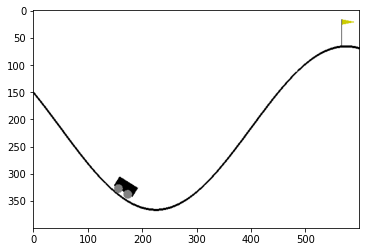

Q-value of the current state left=140.23 nothing=129.58 right=118.71
Action: Left


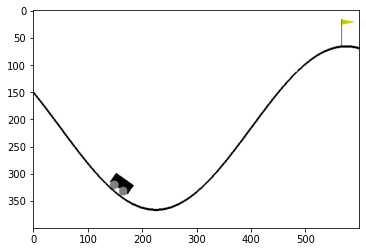

Q-value of the current state left=155.68 nothing=146.05 right=135.62
Action: Left


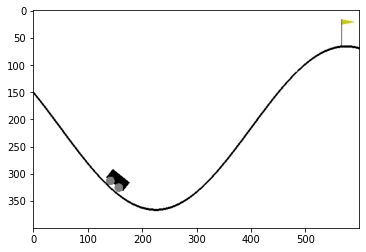

Q-value of the current state left=168.84 nothing=159.68 right=148.82
Action: Left


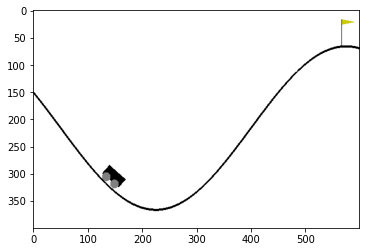

Q-value of the current state left=180.22 nothing=171.52 right=160.11
Action: Left


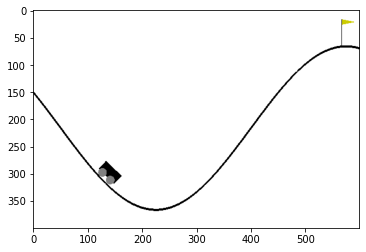

Q-value of the current state left=199.56 nothing=192.06 right=181.24
Action: Left


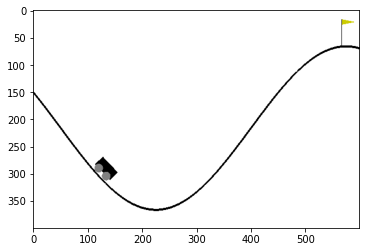

Q-value of the current state left=216.52 nothing=209.97 right=199.65
Action: Left


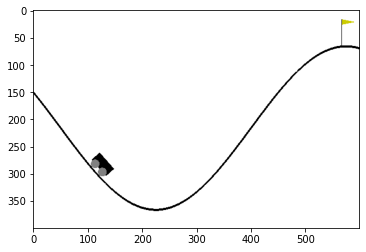

Q-value of the current state left=231.13 nothing=225.30 right=215.35
Action: Left


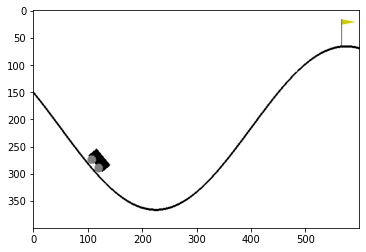

Q-value of the current state left=247.57 nothing=243.07 right=233.96
Action: Left


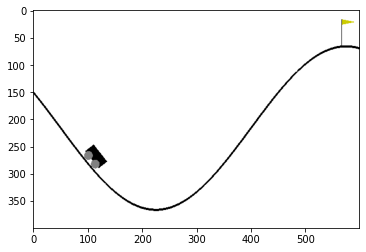

Q-value of the current state left=269.31 nothing=267.45 right=260.17
Action: Left


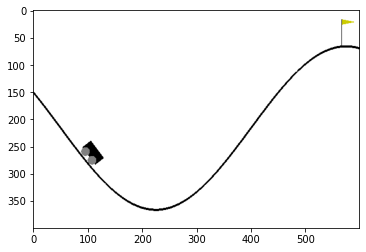

Q-value of the current state left=290.30 nothing=291.13 right=285.78
Action: Nothing


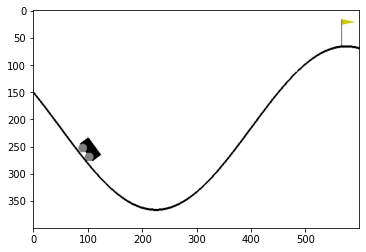

Q-value of the current state left=308.06 nothing=311.34 right=307.69
Action: Nothing


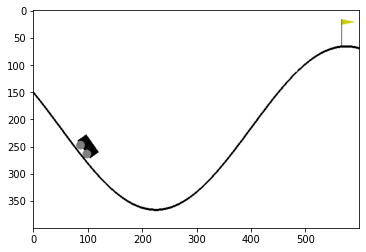

Q-value of the current state left=326.06 nothing=332.08 right=330.34
Action: Nothing


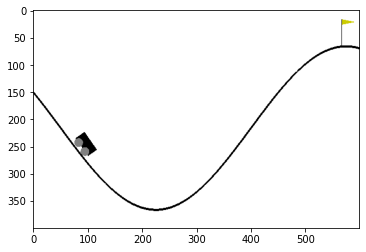

Q-value of the current state left=346.99 nothing=356.28 right=356.53
Action: Right


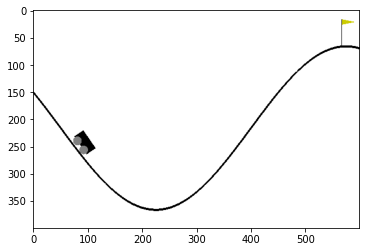

Q-value of the current state left=366.33 nothing=377.68 right=379.52
Action: Right


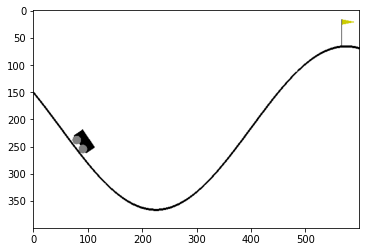

Q-value of the current state left=386.95 nothing=399.91 right=404.08
Action: Right


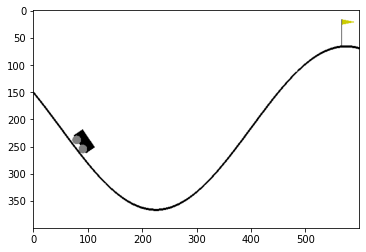

Q-value of the current state left=405.04 nothing=419.96 right=426.88
Action: Right


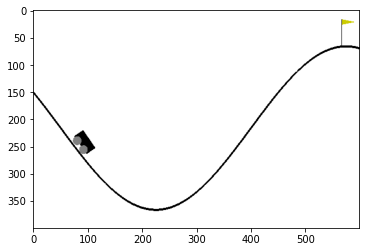

Q-value of the current state left=423.86 nothing=441.23 right=451.31
Action: Right


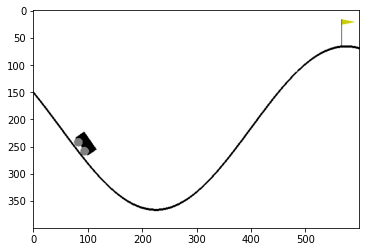

Q-value of the current state left=442.16 nothing=462.34 right=475.69
Action: Right


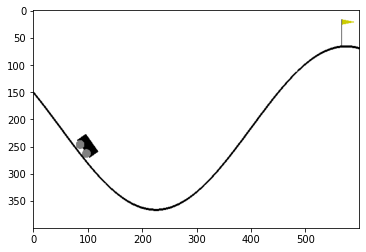

Q-value of the current state left=453.21 nothing=474.41 right=492.86
Action: Right


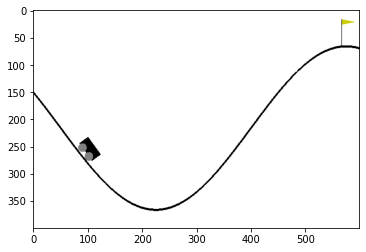

Q-value of the current state left=474.47 nothing=498.07 right=520.91
Action: Right


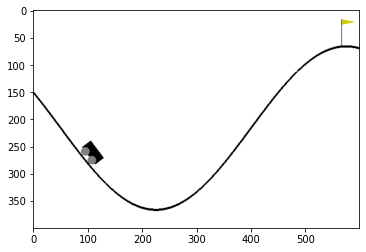

Q-value of the current state left=492.25 nothing=521.58 right=549.75
Action: Right


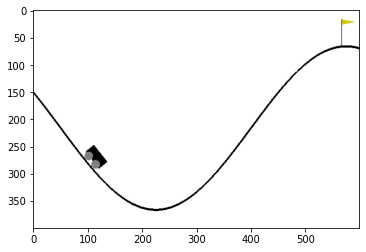

Q-value of the current state left=502.41 nothing=538.03 right=572.89
Action: Right


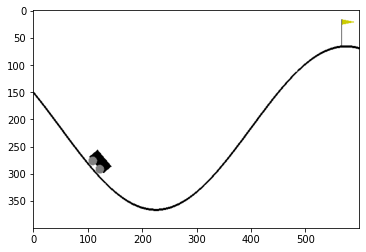

Q-value of the current state left=538.98 nothing=575.86 right=615.89
Action: Right


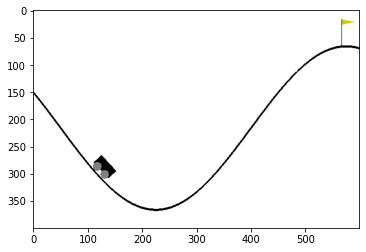

Q-value of the current state left=571.79 nothing=610.04 right=654.73
Action: Right


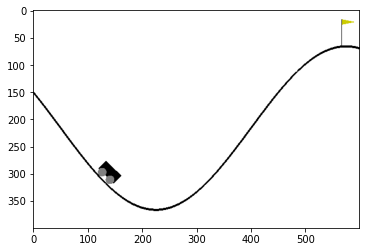

Q-value of the current state left=595.79 nothing=634.95 right=685.04
Action: Right


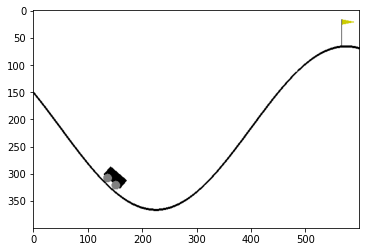

Q-value of the current state left=633.69 nothing=676.36 right=732.73
Action: Right


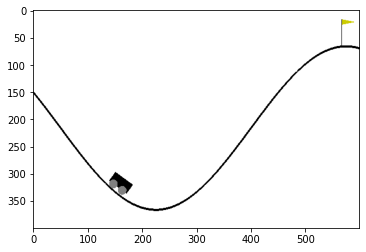

Q-value of the current state left=667.27 nothing=714.41 right=777.65
Action: Right


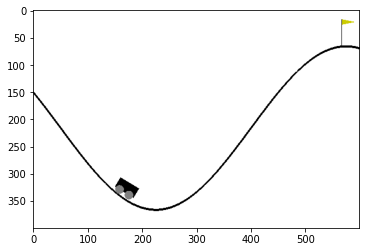

Q-value of the current state left=682.25 nothing=733.35 right=803.21
Action: Right


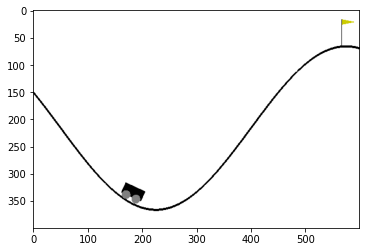

Q-value of the current state left=703.73 nothing=760.25 right=836.33
Action: Right


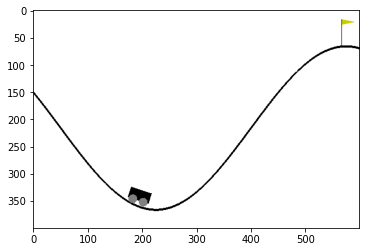

Q-value of the current state left=730.93 nothing=793.78 right=875.81
Action: Right


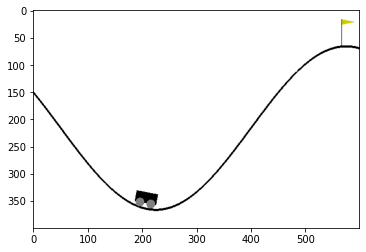

Q-value of the current state left=770.65 nothing=841.13 right=928.91
Action: Right


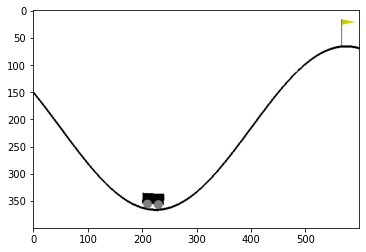

Q-value of the current state left=786.88 nothing=862.78 right=955.93
Action: Right


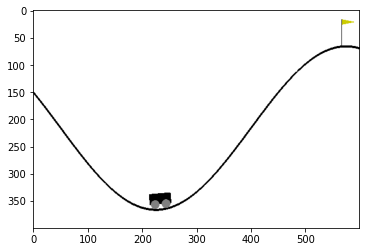

Q-value of the current state left=832.12 nothing=912.20 right=1009.15
Action: Right


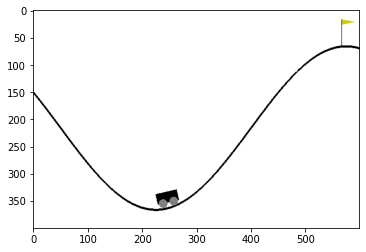

Q-value of the current state left=865.13 nothing=952.33 right=1051.86
Action: Right


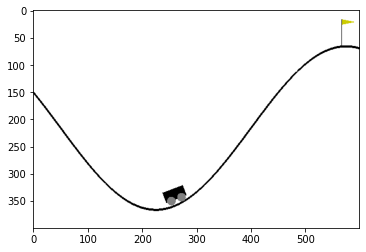

Q-value of the current state left=890.60 nothing=984.87 right=1086.01
Action: Right


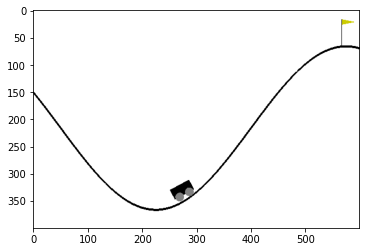

Q-value of the current state left=931.09 nothing=1041.80 right=1147.09
Action: Right


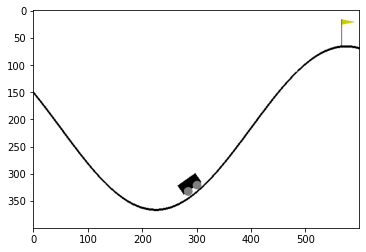

Q-value of the current state left=981.87 nothing=1101.04 right=1210.00
Action: Right


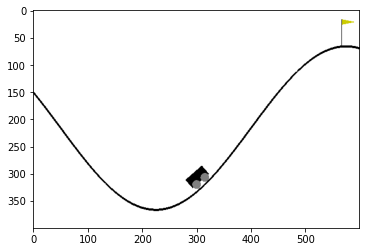

Q-value of the current state left=1040.26 nothing=1162.91 right=1273.19
Action: Right


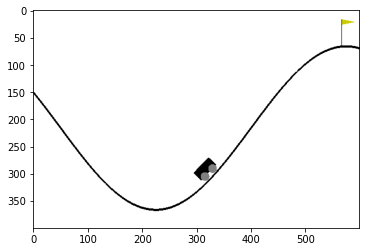

Q-value of the current state left=1094.90 nothing=1220.46 right=1332.34
Action: Right


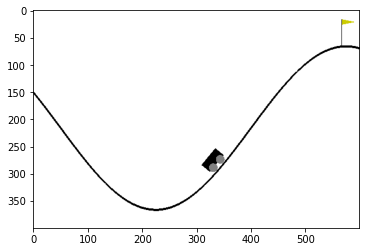

Q-value of the current state left=1144.58 nothing=1270.27 right=1383.58
Action: Right


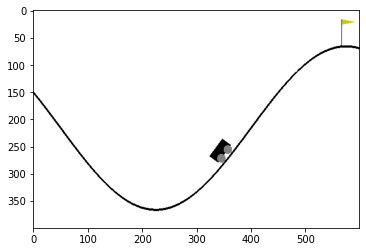

Q-value of the current state left=1209.01 nothing=1329.02 right=1440.65
Action: Right


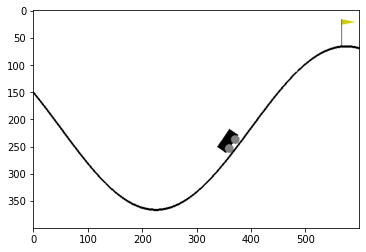

Q-value of the current state left=1298.91 nothing=1415.91 right=1524.06
Action: Right


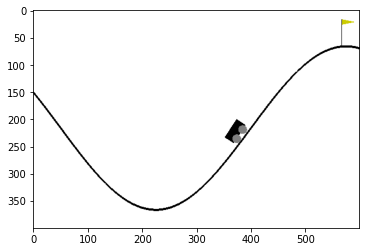

Q-value of the current state left=1373.67 nothing=1487.16 right=1592.20
Action: Right


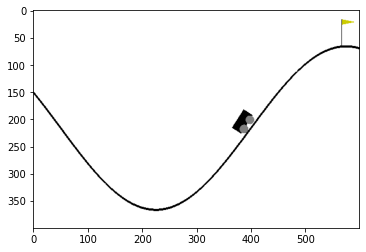

Q-value of the current state left=1438.06 nothing=1547.74 right=1649.86
Action: Right


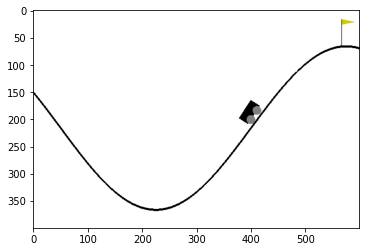

Q-value of the current state left=1512.83 nothing=1619.26 right=1717.29
Action: Right


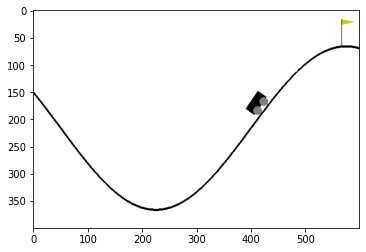

Q-value of the current state left=1590.31 nothing=1694.15 right=1788.78
Action: Right


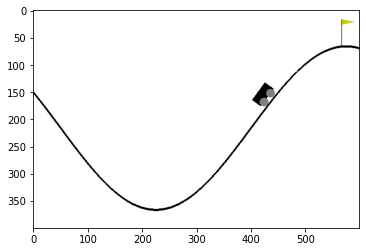

Q-value of the current state left=1667.30 nothing=1768.44 right=1860.01
Action: Right


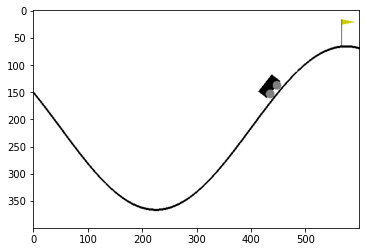

Q-value of the current state left=1744.07 nothing=1843.63 right=1933.09
Action: Right


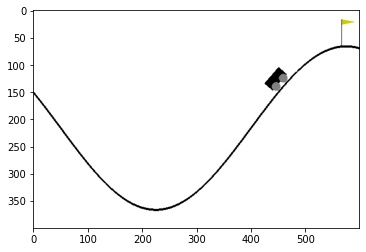

Q-value of the current state left=1822.11 nothing=1919.91 right=2007.32
Action: Right


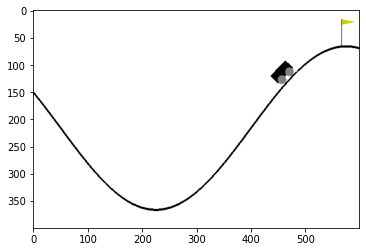

Q-value of the current state left=1902.43 nothing=1997.62 right=2082.41
Action: Right


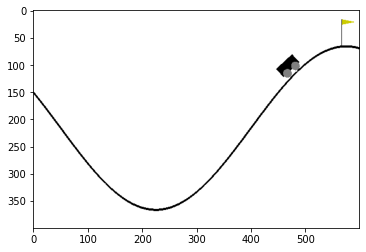

Q-value of the current state left=1996.24 nothing=2086.65 right=2167.17
Action: Right


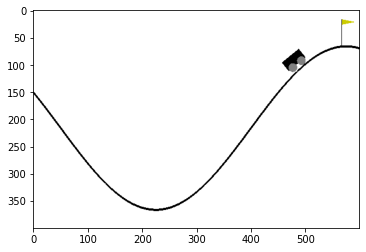

Q-value of the current state left=2094.21 nothing=2178.99 right=2255.57
Action: Right


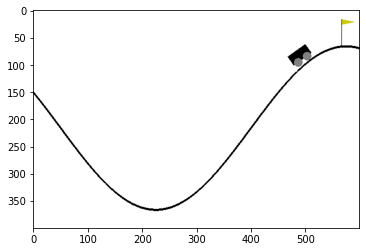

Q-value of the current state left=2192.03 nothing=2272.03 right=2345.44
Action: Right


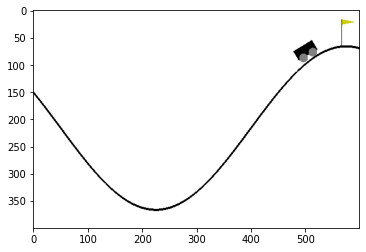

Q-value of the current state left=2292.06 nothing=2368.13 right=2438.27
Action: Right


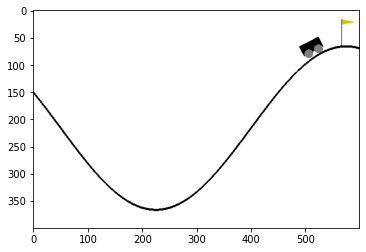

Q-value of the current state left=2389.22 nothing=2464.36 right=2532.60
Action: Right


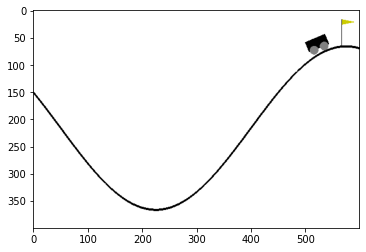

Q-value of the current state left=2489.10 nothing=2563.56 right=2630.46
Action: Right


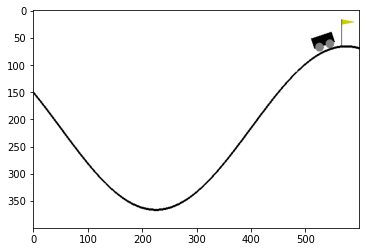

Q-value of the current state left=2588.43 nothing=2662.81 right=2729.48
Action: Right


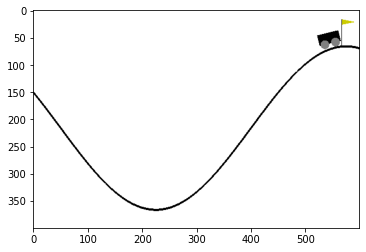

Q-value of the current state left=2689.89 nothing=2764.04 right=2830.95
Action: Right


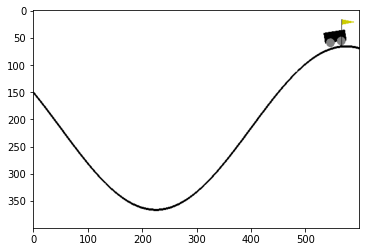

Q-value of the current state left=2801.61 nothing=2874.36 right=2941.21
Action: Right


In [40]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_model, obs)

    # Take greedy-action
    action, _ = dqn_model.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, done, info = env.step(action)

    episode_rewards.append(reward)


### Exercise (3 minutes): compare estimated initial q-value with actual discounted return

Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor `dqn_model.gamma`

In [42]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor
power = 0
for idx, k in enumerate(episode_rewards):
  sum_discounted_rewards += k *(dqn_model.gamma ** idx)

### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -64.48, initial q-value -34.26


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [52]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = next_q_values_online.argmax(dim=1)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = next_q_values.gather(1, next_actions_online.unsqueeze(-1)).squeeze(-1)
               
                # 1-step TD target
                rewards = replay_data.rewards
                dones = replay_data.dones
                next_q_values_masked = (1 - dones) * self.gamma * next_q_values
                target_q_values = rewards + next_q_values_masked

                #target_q_values = ...

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.huber_loss(target_q_values, current_q_values)

            ### END OF YOUR CODE
            
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [44]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset() for _ in range(n_samples)])
    
    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [45]:
dqn_model = DQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Define the callback

In [46]:
monitor_dqn_value_cb = MonitorQValueCallback()

In [47]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

Logging to data/tb/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1152     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 674      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.00231  |
|    n_updates        | 296      |
----------------------------------
----------------------------------
| rollout/            |       

### Double DQN

In [48]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [49]:
monitor_double_q_value_cb = MonitorQValueCallback()

In [53]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

Logging to data/tb/DQN_4


AssertionError: ignored

### Evolution of the max q-value for start states over time

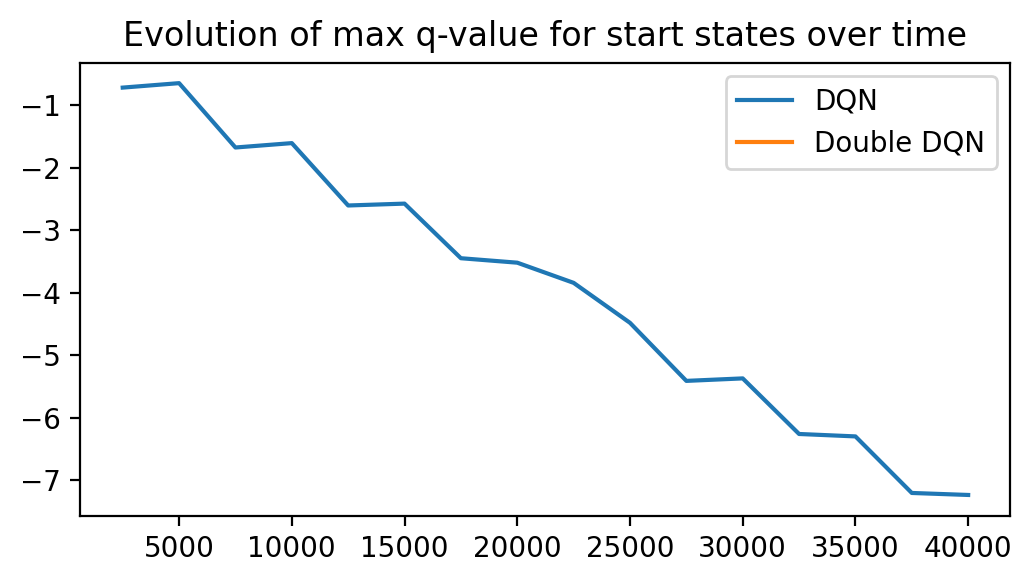

In [51]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()